In [1]:
import numpy as np
import pandas as pd
import glob
import os
from importlib import reload

In [2]:
from sklearn.neighbors import KernelDensity
import geopandas
import cartopy.io.img_tiles as cimgt

import cartopy as cart
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from cartopy import config
from shapely.geometry import Point
from shapely.prepared import prep
import cartopy

import shapely.geometry as sgeom
from scipy.io import netcdf

import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
warnings.filterwarnings("ignore", module = "matplotlib\..*" )

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [3]:
# request data for use by geopandas
resolution = '10m'
category = 'cultural'
name = 'admin_0_countries'

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')

shpfilename = shpreader.natural_earth(resolution, category, name)
df = geopandas.read_file(shpfilename)
ll_proj = ccrs.PlateCarree()  #CRS for raw long/lat
land_10m = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m')
land_polygons = list(land_10m.geometries())

In [5]:
src = '../results/'
dst = '../plots/'

filename = src + 'tally_merged_locations.csv'
data = pd.read_csv(filename)

print(data.shape)
countries = pd.unique(data.country)

#data.head()

(6424, 6)


In [6]:
dfcountry = data.copy()

rlatlon = dfcountry.iloc[:, 4:].values
rlatlonr = rlatlon*np.pi / 180.0  # Convert lat/long to radians

print(dfcountry.shape)
dfcountry.head()

(6424, 6)


,incountry_rank,country,location,score,latitude,longitude
0,0,Afghanistan,"Kabul, Afghanistan",7,34.555349,69.207486
1,1,Afghanistan,"Kandahar, Afghanistan",3,31.628871,65.737175
2,2,Afghanistan,"Lashkar Gah, Helmand, Afghanistan",2,31.609565,64.408208
3,3,Afghanistan,"Jalalabad, Afghanistan",1,34.428353,70.457802
4,4,Afghanistan,"Herat, Afghanistan",1,34.352865,62.204029


In [8]:
pad1 = .1  #padding, degrees unit

poly = [land_polygons[0]]

exts = [poly[0].bounds[0], poly[0].bounds[2], poly[0].bounds[1], poly[0].bounds[3]];
exts[2] = -55
rmask = (rlatlon[:, 0] > exts[2]) & (rlatlon[:, 0] < exts[3]) & (rlatlon[:,1] > exts[0]) & (rlatlon[:,1] < exts[1])

rscore = dfcountry['score'].values.copy()
rscore = rscore[rmask]

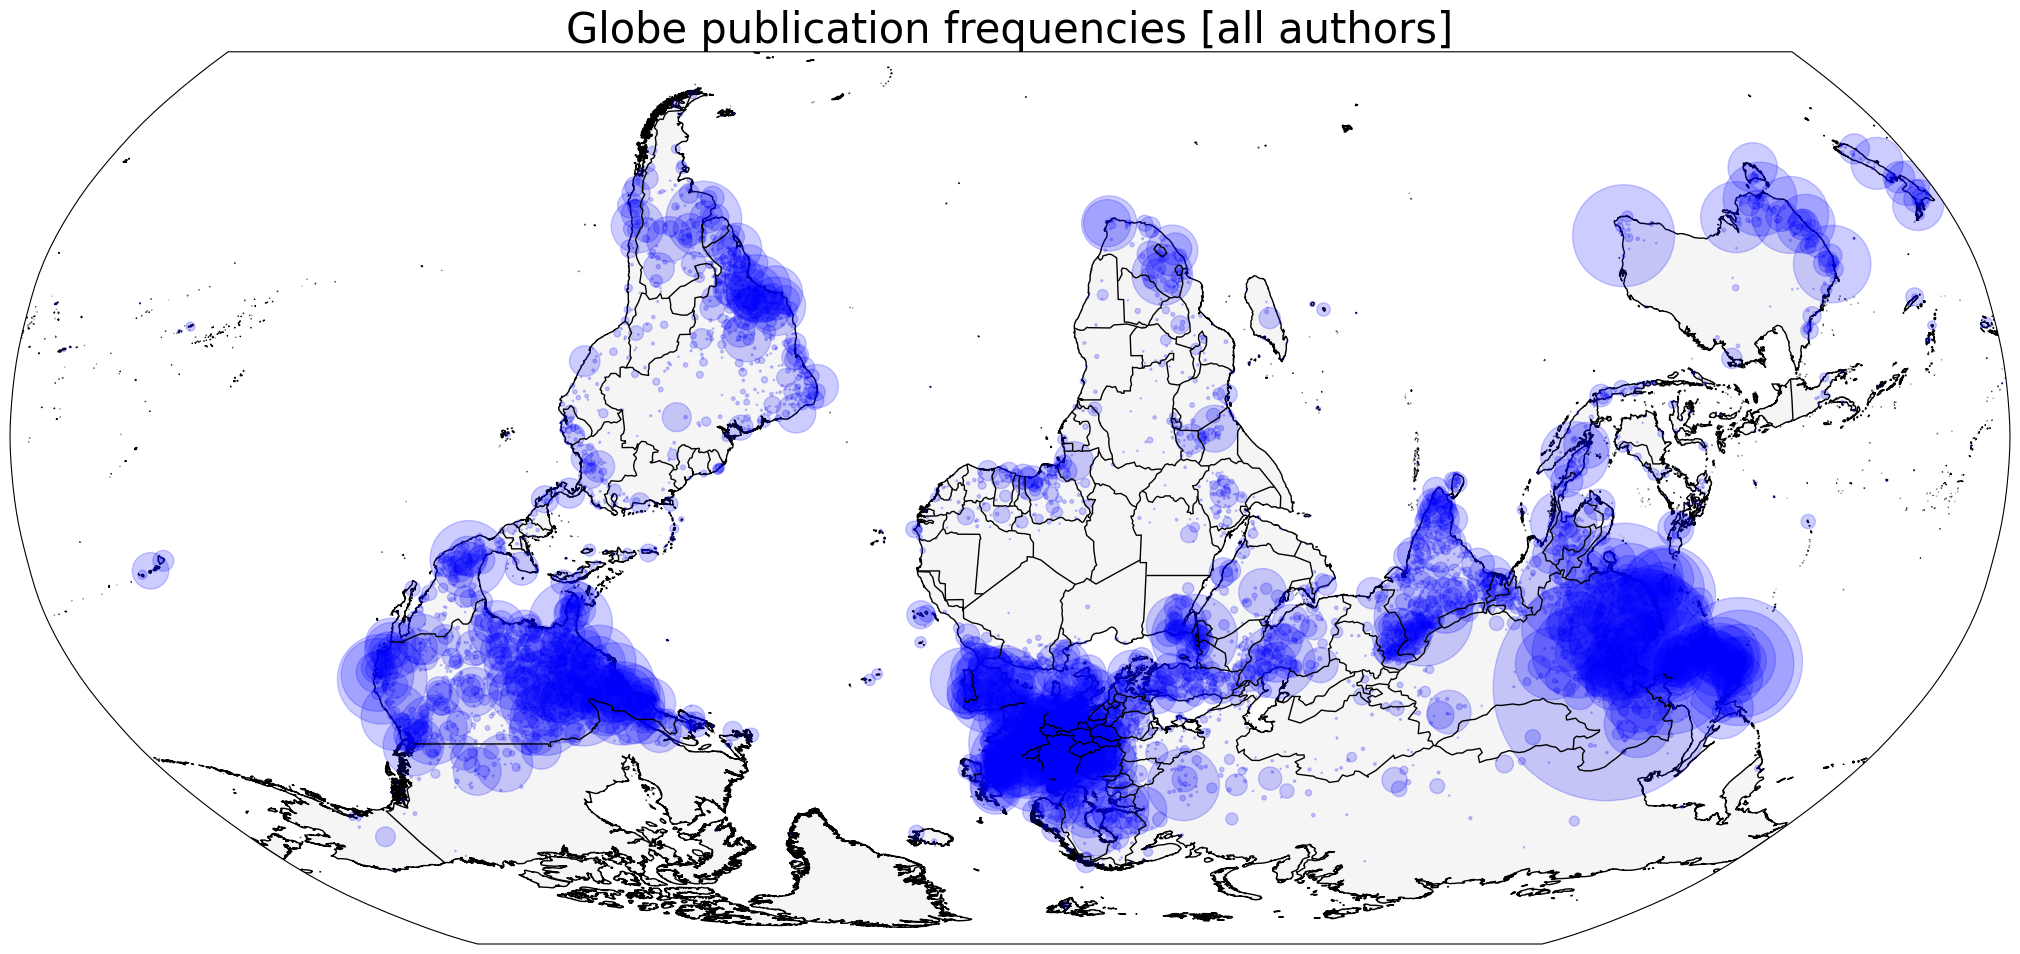

In [9]:
prj = ccrs.Robinson()
#prj = ccrs.RotatedPole(pole_latitude=45, pole_longitude=180)
trn = ccrs.PlateCarree()
#trn = ccrs.RotatedPole(pole_latitude=45, pole_longitude=180)
fig = plt.figure(figsize=(20, 10))
ax = fig.add_axes([0, 0, 1, 1], projection=prj)
#score[score > 1000] = 1000

ax.add_feature(land_10m, zorder=0, edgecolor='black', facecolor='whitesmoke')
ax.scatter(dfcountry.longitude[rmask], dfcountry.latitude[rmask], transform=trn, 
           s=rscore, marker='o', alpha=0.2, zorder=2, color='blue');
ax.scatter(exts[:2], exts[2:], transform=trn, facecolor='whitesmoke')

ax.add_feature(cfeature.BORDERS, zorder=19, edgecolor='black', linestyle='-');

ax.set_title('Globe publication frequencies [all authors]', fontsize=30)

filename = dst + 'frequencies_globe'
#plt.savefig(filename + '.jpg', dpi=150, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})

fig.gca().invert_yaxis()

filename = dst + 'frequencies_globe_inv'
#plt.savefig(filename + '.jpg', dpi=150, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})

In [8]:
resol = 0.4
lons = np.arange(exts[0], exts[1], resol)
lats = np.arange(exts[2], exts[3], resol)
lon_grid, lat_grid = np.meshgrid(lons, lats)

points = [Point(point) for point in zip(lon_grid.ravel(), lat_grid.ravel())]


land_polygon = prep(poly[0])

land = []
land.extend([tuple(point.coords)[0] for point in filter(land_polygon.covers, points)])
    
xy = np.pi*np.asarray(land)/180.0
xy = xy[:, [1,0]]
print(xy.shape)

(132777, 2)


In [9]:
bw = 0.03
kde_params = {'bandwidth': bw, 'metric':'haversine', 'kernel':'gaussian', 'algorithm':'ball_tree'}

rkde = KernelDensity(**kde_params)
rkde.fit(rlatlonr[rmask,:], sample_weight=rscore)

rout = np.exp(rkde.score_samples(xy))
print(np.max(rout))
len(rout)

6.7542638069566845


132777

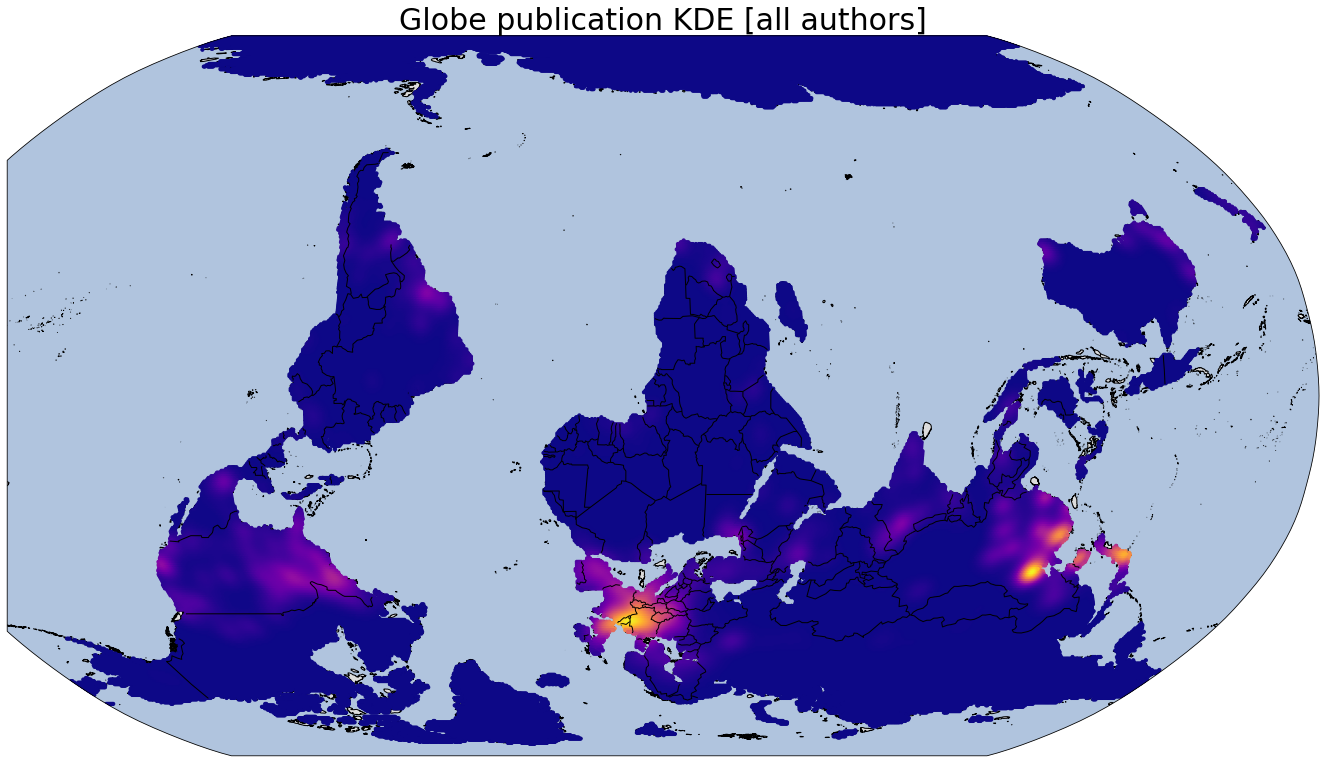

In [10]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_axes([0, 0, 1, 1], projection=prj)

ax.set_facecolor('lightsteelblue')
ax.add_feature(land_10m, zorder=0, edgecolor='black', facecolor='gainsboro')

xs, ys = zip(*land)
ax.scatter(xs, ys, transform=trn, s=10, marker='o', c=rout, alpha=1, zorder=2, cmap='plasma');
ax.add_feature(cfeature.BORDERS, zorder=19, edgecolor='gainsboro', linestyle='-');

ax.set_title('Globe publication KDE [all authors]', fontsize=30)

filename = dst + 'kde_globe'
plt.savefig(filename + '.jpg', dpi=150, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})

fig.gca().invert_yaxis()

filename = dst + 'kde_globe_inv'
plt.savefig(filename + '.jpg', dpi=150, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})

## Population density

In [11]:
popdata = pd.read_csv('../data/worldcities.csv')

popdata = popdata[popdata.population > 1e4]
popdata.population /= 1e4

print(popdata.shape)
popdata.head(5)

(28260, 11)


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.6839,139.7744,Japan,JP,JPN,Tōkyō,primary,3910.5,1392685764
1,Jakarta,Jakarta,-6.2146,106.8451,Indonesia,ID,IDN,Jakarta,primary,3536.2,1360771077
2,Delhi,Delhi,28.6667,77.2167,India,IN,IND,Delhi,admin,3187.0,1356872604
3,Manila,Manila,14.6000,120.9833,Philippines,PH,PHL,Manila,primary,2397.1,1608618140
4,São Paulo,Sao Paulo,-23.5504,-46.6339,Brazil,BR,BRA,São Paulo,admin,2249.5,1076532519


In [12]:
cpop = popdata.copy()
pmask = (cpop.lat > exts[2]) & (cpop.lat < exts[3]) & (cpop.lng > exts[0]) & (cpop.lng < exts[1])

pscore = cpop.population.values.copy()
pscore = pscore[pmask]

In [ ]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_axes([0, 0, 1, 1], projection=prj)

ax.add_feature(land_10m, zorder=0, edgecolor='black', facecolor='whitesmoke')
ax.scatter(cpop.lng[pmask], cpop.lat[pmask], transform=trn, 
           s=pscore, marker='o', alpha=0.3, zorder=2, color='red');
ax.scatter(exts[:2], exts[2:], transform=trn, facecolor='whitesmoke')

ax.add_feature(cfeature.BORDERS, zorder=19, edgecolor='black', linestyle='-');

ax.set_title('Globe population KDE [all authors]', fontsize=30)

filename = dst + 'population_globe'
plt.savefig(filename + '.jpg', dpi=150, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})

fig.gca().invert_yaxis()

filename = dst + 'population_globe_inv'
plt.savefig(filename + '.jpg', dpi=150, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})

In [ ]:
pkde = KernelDensity(**kde_params)
platlonr = cpop.loc[:, ['lat','lng']].values
platlonr = platlonr*np.pi / 180.0
pkde.fit(platlonr[pmask,:], sample_weight=pscore)

pout = np.exp(pkde.score_samples(xy))
print(np.max(pout))
len(pout)

In [ ]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_axes([0, 0, 1, 1], projection=prj)

ax.set_facecolor('lightsteelblue')
ax.add_feature(land_10m, zorder=0, edgecolor='black', facecolor='gainsboro')

xs, ys = zip(*land)
ax.scatter(xs, ys, transform=trn, s=15, marker='o', c=pout, alpha=1, zorder=2, cmap='magma');

ax.add_feature(cfeature.BORDERS, zorder=19, edgecolor='black', linestyle='-');

ax.set_title('Globe population KDE [all authors]', fontsize=30)

filename = dst + 'kde_population_globe'
plt.savefig(filename + '.jpg', dpi=150, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})

fig.gca().invert_yaxis()

filename = dst + 'kde_population_globe_inv'
plt.savefig(filename + '.jpg', dpi=150, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})

In [ ]:
print(np.sum(pout), np.sum(rout))
print(np.sum(np.log(pout)), np.sum(np.log(rout)))

In [ ]:
foo = pd.DataFrame()
foo['Population'] = pout
foo['Research'] = rout
foo['Pop-Res'] = pout - rout
foo.describe()

In [ ]:
filename = src + 'research_population_global_kde.csv'
foo.to_csv(filename, index=False)

In [ ]:
from matplotlib import colors
divnorm=colors.TwoSlopeNorm(vcenter=0.)

fig = plt.figure(figsize=(20, 9))
ax = fig.add_axes([0, 0, 1, 1], projection=prj)

ax.set_facecolor('lightsteelblue')
ax.add_feature(land_10m, zorder=0, edgecolor='black', facecolor='gainsboro')

xs, ys = zip(*land)
cs = ax.scatter(xs, ys, transform=trn, s=15, marker='o', 
                c=pout-rout, alpha=1, zorder=2, cmap='seismic', norm=divnorm);

ax.add_feature(cfeature.BORDERS, zorder=19, edgecolor='black', linestyle='-');
cbar = fig.colorbar(cs, pad=0.01)
cbar.ax.tick_params(labelsize=20);

ax.set_title('Population KDE - Research KDE', fontsize=fs+10);

filename = dst + 'kde_difference_globe'
plt.savefig(filename + '.jpg', dpi=150, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})

fig.gca().invert_yaxis()

filename = dst + 'kde_difference_globe_inv'
plt.savefig(filename + '.jpg', dpi=150, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})

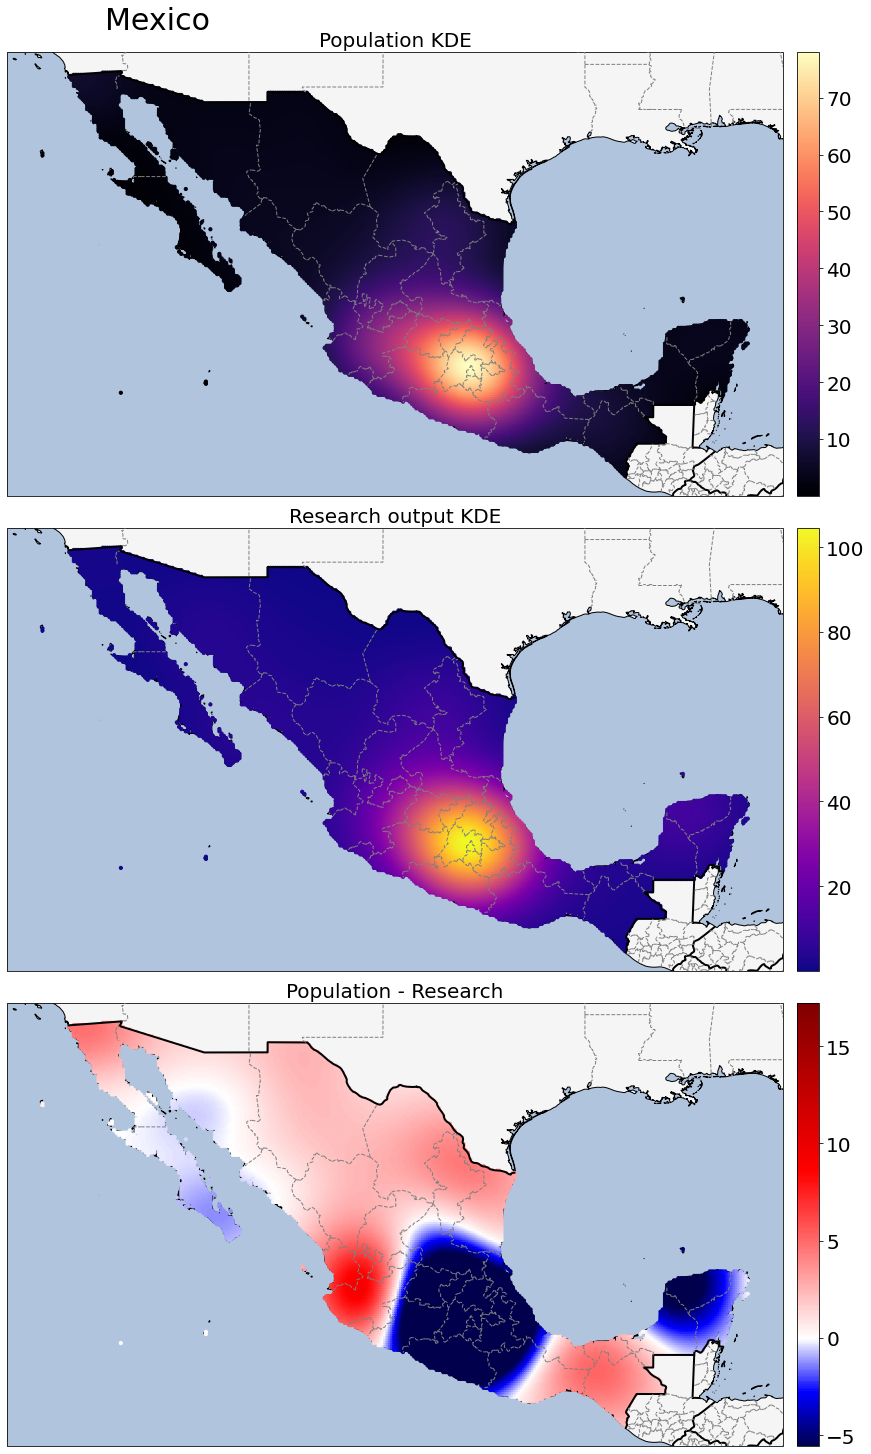

In [206]:
fs, pad, frac, s = 20, 0.01, 0.03, 10
fig, axs = plt.subplots(nrows=3,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(20,20), sharex=True, sharey=True)
axs=axs.flatten()
i = 0
cs = axs[i].scatter(xs, ys, transform=ccrs.PlateCarree(), s=s, marker='o', c=pout, alpha=1, zorder=2, cmap='magma');
cbar = fig.colorbar(cs, fraction=frac, pad=pad, ax=axs[i])
cbar.ax.tick_params(labelsize=fs);

i += 1
cs = axs[i].scatter(xs, ys, transform=ccrs.PlateCarree(), s=s, marker='o', c=rout, alpha=1, zorder=2, cmap='plasma');
cbar = fig.colorbar(cs, fraction=frac, pad=pad, ax=axs[i])
cbar.ax.tick_params(labelsize=fs);

i += 1
cs = axs[i].scatter(xs, ys, transform=ccrs.PlateCarree(), s=s, marker='o', c=pout-rout, 
                    alpha=1, zorder=2, cmap='seismic', norm=divnorm);
cbar = fig.colorbar(cs, fraction=frac, pad=pad, ax=axs[i])
cbar.ax.tick_params(labelsize=fs);

for i in range(len(axs)):
    axs[i].set_facecolor('lightsteelblue')
    axs[i].add_feature(land_10m, zorder=0, edgecolor='black', facecolor='whitesmoke')
    axs[i].add_feature(states_provinces, edgecolor='gray', linestyle='--', zorder=20);
    axs[i].add_feature(cfeature.BORDERS, zorder=19, edgecolor='black', linestyle='-', lw=2);
    
axs[1].set_title('Research output KDE', fontsize=fs)
axs[0].set_title('Population KDE', fontsize=fs)
axs[2].set_title('Population - Research', fontsize=fs)

fig.tight_layout();
fig.suptitle(countries[kdx], y=1.01, fontsize=10+fs);

filename = dst + 'comparison_v_kde_' + countries[kdx].lower()
plt.savefig(filename + '.jpg', dpi=150, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})

# tj

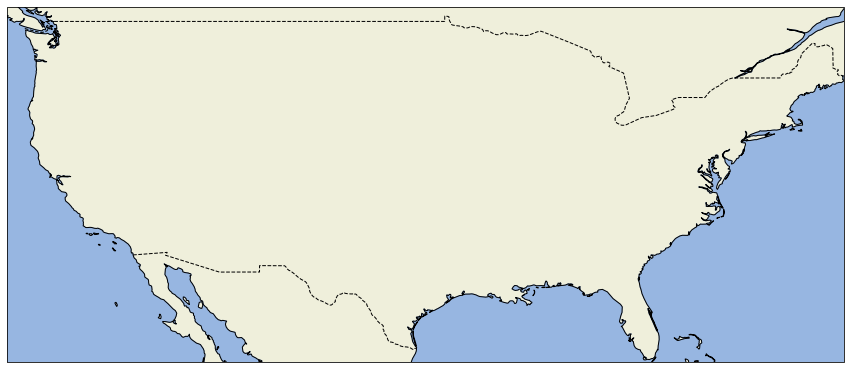

In [15]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-126, -67, 50, 25], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle='--');
#ax.add_feature(cfeature.LAKES, alpha=0.5)
#ax.add_feature(cfeature.RIVERS)

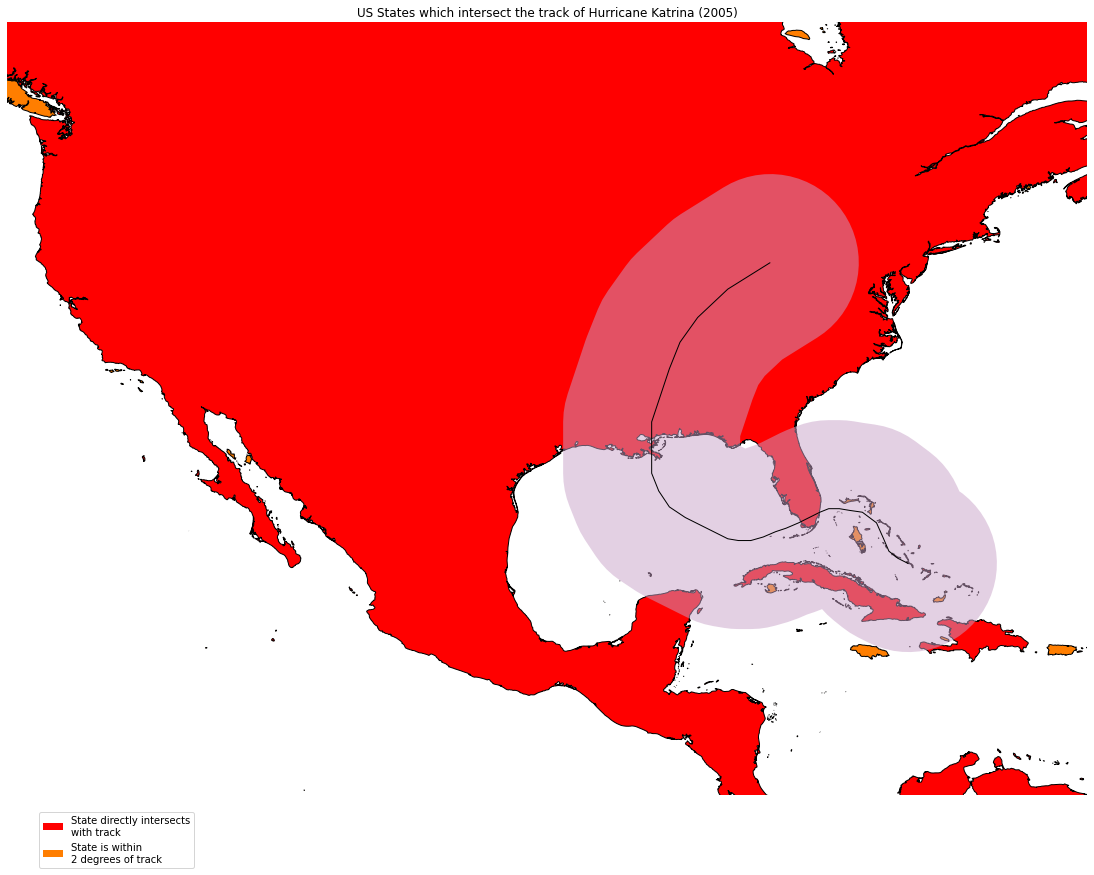

In [26]:
def sample_data():
    lons = [-75.1, -75.7, -76.2, -76.5, -76.9, -77.7, -78.4, -79.0,
            -79.6, -80.1, -80.3, -81.3, -82.0, -82.6, -83.3, -84.0,
            -84.7, -85.3, -85.9, -86.7, -87.7, -88.6, -89.2, -89.6,
            -89.6, -89.6, -89.6, -89.6, -89.1, -88.6, -88.0, -87.0,
            -85.3, -82.9]

    lats = [23.1, 23.4, 23.8, 24.5, 25.4, 26.0, 26.1, 26.2, 26.2, 26.0,
            25.9, 25.4, 25.1, 24.9, 24.6, 24.4, 24.4, 24.5, 24.8, 25.2,
            25.7, 26.3, 27.2, 28.2, 29.3, 29.5, 30.2, 31.1, 32.6, 34.1,
            35.6, 37.0, 38.6, 40.1]

    return lons, lats

fig = plt.figure(figsize=(15,15))
# to get the effect of having just the states without a map "background"
# turn off the background patch and axes frame
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.PlateCarree(),
                  frameon=False)
ax.patch.set_visible(False)

ax.set_extent([-126, -65, 10, 50], ccrs.Geodetic())

shapename = 'land'
#shapename = 'admin_0_countries'
#shapename = 'admin_1_states_provinces'
#shapename = 'roads'
states_shp = shpreader.natural_earth(resolution='10m',
                                     category='physical', name=shapename)

lons, lats = sample_data()

ax.set_title('US States which intersect the track of '
             'Hurricane Katrina (2005)')

# turn the lons and lats into a shapely LineString
track = sgeom.LineString(zip(lons, lats))

# buffer the linestring by two degrees (note: this is a non-physical
# distance)
track_buffer = track.buffer(5)

def colorize_state(geometry):
    facecolor = (0.9375, 0.9375, 0.859375)
    if geometry.intersects(track):
        facecolor = 'red'
    elif geometry.intersects(track_buffer):
        facecolor = '#FF7E00'
    return {'facecolor': facecolor, 'edgecolor': 'black'}

ax.add_geometries(
    shpreader.Reader(states_shp).geometries(),
    ccrs.PlateCarree(),
    styler=colorize_state)

ax.add_geometries([track_buffer], ccrs.PlateCarree(),
                  facecolor='#C8A2C8', alpha=0.5)
ax.add_geometries([track], ccrs.PlateCarree(),
                  facecolor='none', edgecolor='k')

# make two proxy artists to add to a legend
direct_hit = mpatches.Rectangle((0, 0), 1, 1, facecolor="red")
within_2_deg = mpatches.Rectangle((0, 0), 1, 1, facecolor="#FF7E00")
labels = ['State directly intersects\nwith track',
          'State is within \n2 degrees of track']
ax.legend([direct_hit, within_2_deg], labels,
          loc='lower left', bbox_to_anchor=(0.025, -0.1), fancybox=True)

plt.show()

In [31]:
list(shpreader.Reader(states_shp).geometries())

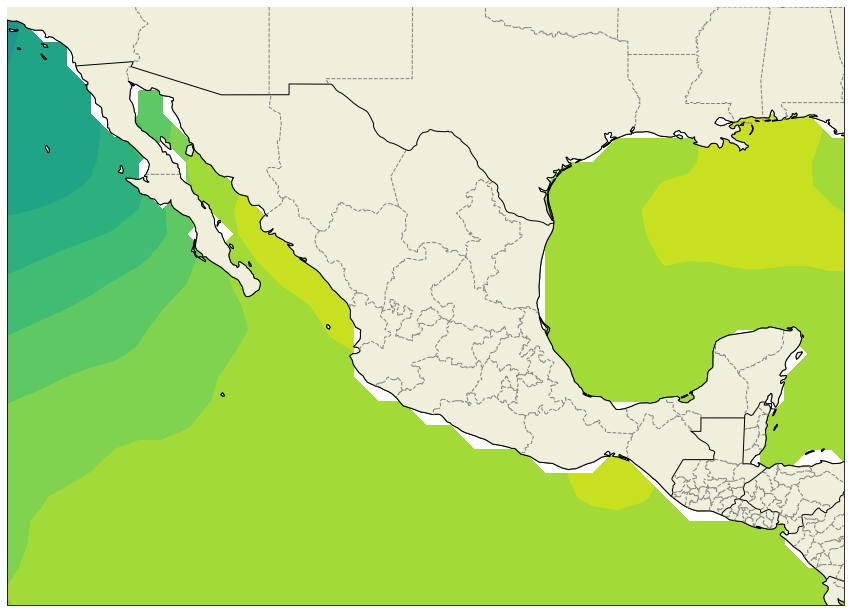

In [16]:
# get the path of the file. It can be found in the repo data directory.
fname = os.path.join(config["repo_data_dir"],
                     'netcdf', 'HadISST1_SST_update.nc'
                     )

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')

dataset = netcdf.netcdf_file(fname, maskandscale=True, mmap=False)
sst = dataset.variables['sst'][0, :, :]
#sst.mask = ~sst.mask
lats = dataset.variables['lat'][:]
lons = dataset.variables['lon'][:]

fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-120, -85, 10, 35], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, zorder=19, linestyle='-')
ax.add_feature(cfeature.LAND, zorder=18, edgecolor='k')
ax.add_feature(states_provinces, edgecolor='gray', linestyle='--', zorder=20)

plt.contourf(lons, lats, sst, 20,
             transform = ccrs.PlateCarree())

ax.coastlines();